In [1]:
# --- IMPORTS ---
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
from joblib import dump

In [ ]:
# --- Importer les fichiers csv en pandas ---
nom_du_fichier_csv = '/Users/marche/Documents/Centrale 3A/Apprentissage_Automatique_Project/Python_files/csv_files/train_bdd_clean.csv'
data = pd.read_csv(nom_du_fichier_csv)

nom_du_fichier = "/Users/marche/Documents/Centrale 3A/Apprentissage_Automatique_Project/Python_files/csv_files/pred_retard.csv"
y = data["retard_moyen_tous_trains_arrivee"]
X = pd.read_csv(nom_du_fichier)


# --- Diviser le dataset en trainset et testset ---
# Le trainset s'étend de janvier 2018 à decembre 2022, et le testset de janvier à juin 2023
separation_date = 2023

# Masque pour les données de test (annee == 2023)
test_mask = (data['annee'] == separation_date)

# Masque pour les données d'entraînement (annee < 2023)
train_mask = (data['annee'] < separation_date)

# Séparer les données en trainset et testset
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

In [ ]:
# --- Obtenir la liste des features de X classées par ordre de corrélation décroissante avec la variable y ---
correlation_matrix = X.corrwith(y)
pd.set_option('display.max_rows', None)
abs_mat = correlation_matrix.abs()
sorted_correlation = abs_mat.sort_values(ascending=False)
print(sorted_correlation)

Distance (km)                             0.169846
Latitude_depart                           0.109289
DEPART_ITALIE                             0.098802
national_service                          0.086960
DEPART_PARIS MONTPARNASSE                 0.069960
ARRIVEE_MARSEILLE ST CHARLES              0.068714
Longitude_arrivee                         0.064434
DEPART_MARSEILLE ST CHARLES               0.058092
DEPART_BARCELONA                          0.055957
nb_train_prevu                            0.052080
ARRIVEE_NANTES                            0.051538
DEPART_CHAMBERY CHALLES LES EAUX          0.050853
DEPART_LYON PART DIEU                     0.048937
DEPART_STRASBOURG                         0.047698
DEPART_PARIS NORD                         0.047050
ARRIVEE_TOURCOING                         0.047004
DEPART_TOULOUSE MATABIAU                  0.042423
ARRIVEE_LILLE                             0.041921
ARRIVEE_MARNE LA VALLEE                   0.041797
DEPART_MADRID                  

13.296231740510196
82.82514305336176
14.018923145148412
14.58909646994183
14.509292841878093
12.443892836905283
11.991043818074147
12.522656206444323
12.335871631940377
18.35276156147897
16.566599871825808
16.596484591023263
16.58333717353327
18.356818649106387
16.74786054683733
15.58394172574577
15.812774200684972
16.063435333183616
15.701060794865414
15.777851393345417
15.925989940430206
17.543939199935295
17.698745779304886
15.766027245666168
17.65097802702253
17.60102275642347
17.610709997067413
15.823198208572471
15.752032823833094
16.37103369626643
18.032881188314285
16.336357448771484
17.67888602655901
17.48168595665171
17.484145663940193
15.758180181636464
16.34143171538813
18.232744318300245
15.671542012860867
18.270293060209852
18.030359753629213
18.087090575989347
16.51163603895139
18.052430319897468
18.333535958108577
16.4184977773777
17.456453290521097
17.533550202630625
17.45453576060403
17.270519415113146
15.609049457031826
17.721191318019617
17.419286196401725
17.557776

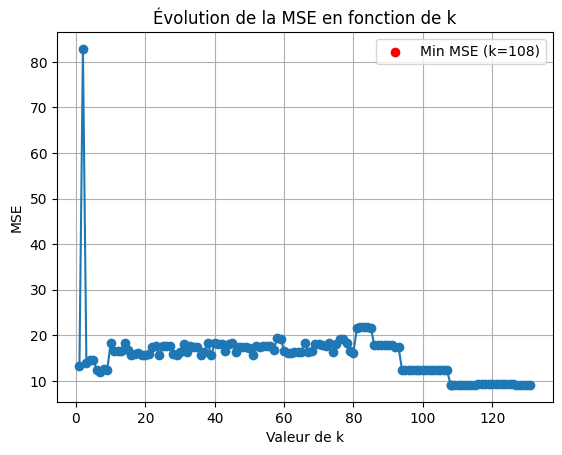

Meilleur k: 108
Meilleure MSE: 9.115081342814976


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------
# Déterminer la meilleure valeur de k pour un modèle de régression k-NN en utilisant une régression k-NN pour différents ensembles de caractéristiques, 
# puis en traçant l'évolution de la MSE en fonction de k, identifiant la meilleure valeur de k et sa MSE minimale
# ----------------------------------------------------------------------------------------------------------------------------------------------------


# Listes pour stocker les scores et les valeurs de k
best_scores = []
best_ks = []
best_mse = np.inf  # Initialisation de la meilleure MSE à une valeur maximale

# Liste vide pour stocker les caractéristiques sélectionnées
selected_features = []

# Parcourir les noms des caractéristiques en ordre
for k in range(1, len(X.columns) + 1):
    # Ajouter le nom de la k-ème caractéristique de sorted_correlation à la liste selected_features
    selected_features.append(sorted_correlation.index[k - 1])

    # Créer la pipeline avec les caractéristiques sélectionnées
    knn_regression_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Étape de standardisation
        ('knn', KNeighborsRegressor())  # Modèle de régression
    ])

    # Entraînement du modèle avec la pipeline
    knn_regression_pipeline.fit(X_train[selected_features], y_train)

    # Évaluer le modèle en calculant la MSE
    y_pred = knn_regression_pipeline.predict(X_test[selected_features])
    mse = mean_squared_error(y_test, y_pred)

    # Mettre à jour la meilleure MSE et la meilleure valeur de k si nécessaire
    print(mse)
    if mse < best_mse:
        best_mse = mse
        best_k = k

    # Ajouter la MSE actuelle et la valeur de k aux listes
    best_scores.append(mse)
    best_ks.append(k)

# Créer un graphique de l'évolution de la MSE en fonction de k
plt.figure()
plt.plot(best_ks, best_scores, marker='o')
plt.title("Évolution de la MSE en fonction de k pour le label retard_moyen_tous_trains_arrivee")
plt.xlabel("Valeur de k")
plt.ylabel("MSE")
plt.grid(True)

# Trouver la valeur de k où la MSE est minimale
min_mse_k = best_ks[np.argmin(best_scores)]
min_mse = min(best_scores)

# Tracer un point à l'emplacement de la MSE minimale
plt.scatter(min_mse_k, min_mse, color='red', label=f'Min MSE (k={min_mse_k})')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

# Afficher la meilleure valeur de k et la meilleure MSE
print("Meilleur k:", min_mse_k)
print("Meilleure MSE:", min_mse)


In [ ]:
# Créer la pipeline pour les K-plus proches voisins (K-NN) en régression
knn_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())  
])

In [ ]:
knn_regression_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'knn', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
Meilleurs hyperparamètres: {'knn__n_neighbors': 48}
Meilleure performance (MSE négatif): 61.6997345447561
Performances de validation croisée (MSE négatif): [ 16.16934419 237.40976307  26.60998664  11.26964604  17.03993278]
Moyenne des performances de validation croisée: 61.6997345447561


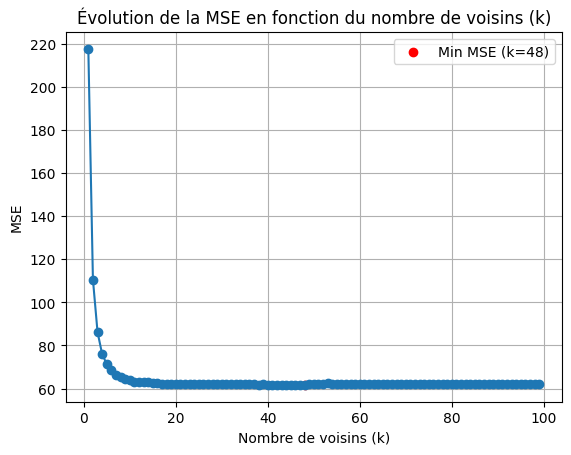

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# Recherche d'hyperparamètres pour le modèle de régression k-NN en utilisant GridSearchCV
# Evaluation des performances du modèle avec validation croisée, en traçant l'évolution de la MSE en fonction du nombre de voisins (k) pour le modèle 
# Identifier le meilleur k et sa MSE minimale
# -------------------------------------------------------------------------------------------------------------------------------------------------------------


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# Définir une grille d'hyperparamètres à tester pour KNN
param_grid = {
    'knn__n_neighbors': list(range(1, 100, 1)),  # Nombre de voisins

}

best_features = sorted_correlation.index[:min_mse_k]
X_best = X[best_features]


model = knn_regression_pipeline  # Utiliser la pipeline KNN
print(model)
# Créer l'objet GridSearchCV avec la métrique appropriée (négatif de l'erreur quadratique moyenne)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuer la recherche sur grille en ajustant le modèle aux données
grid_search.fit(X_best, y)

# Obtenir les meilleurs hyperparamètres et la meilleure performance (négatif de l'erreur quadratique moyenne)
best_params = grid_search.best_params_
best_performance = -grid_search.best_score_

# Appliquer la validation croisée sur le meilleur modèle
best_model = grid_search.best_estimator_
cross_val_scores = -cross_val_score(best_model, X_best, y, cv=5, scoring='neg_mean_squared_error')

# Imprimer les résultats
print("Meilleurs hyperparamètres:", best_params)
print("Meilleure performance (MSE négatif):", best_performance)
print("Performances de validation croisée (MSE négatif):", cross_val_scores)
print("Moyenne des performances de validation croisée:", np.mean(cross_val_scores))

# Récupérer les valeurs de k à partir des paramètres
k_values = [params['knn__n_neighbors'] for params in grid_search.cv_results_['params']]
mse_values = -grid_search.cv_results_['mean_test_score']

# Créer un graphique de l'évolution de la MSE en fonction de k
plt.figure()
plt.plot(k_values, mse_values, marker='o')
plt.title("Évolution de la MSE en fonction du nombre de voisins (k) pour le label retard_moyen_tous_trains_arrivee")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("MSE")
plt.grid(True)

# Trouver la valeur de k où la MSE est minimale
min_mse_k = k_values[np.argmin(mse_values)]
min_mse = min(mse_values)

# Tracer un point à l'emplacement de la MSE minimale
plt.scatter(min_mse_k, min_mse, color='red', label=f'Min MSE (k={min_mse_k})')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()


Erreur quadratique moyenne (MSE) du modèle knn en régression : 9.09


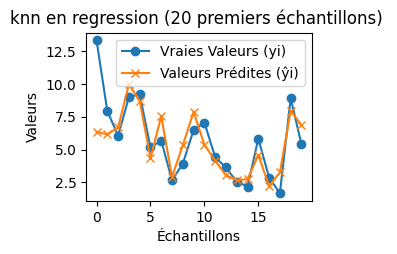

In [74]:
# ----------------------------------------------------------------------------------------------------------------------------
# Utiliser le meilleur hyperparamètre n trouvé précédemment pour créer une pipeline de régression k-NN
# Ajuster le modèle aux données d'entraînement 
# Evaluer sa performance en calculant la MSE entre les valeurs réelles et prédites 
# Afficher un graphique comparant les vraies valeurs et les valeurs prédites pour les 20 premiers échantillons
# ----------------------------------------------------------------------------------------------------------------------------


# On choisit donc 
n = best_params['knn__n_neighbors']

# Créer la pipeline avec la mise à l'échelle et le modèle knn Regressor en utilisant le meilleur hyperparametre n = nb_voisins
final_knn_pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=20))  
])

final_knn_pipeline .fit(X_train, y_train)
model_final_mse = mean_squared_error(y_test, final_knn_pipeline .predict(X_test))
print(f"Erreur quadratique moyenne (MSE) du modèle knn en régression : {model_final_mse:.2f}")

# Modèle knn en régression
plt.subplot(222)
plt.plot(np.arange(20), y_test[:20], label="Vraies Valeurs (yi)", marker='o')
plt.plot(np.arange(20), final_knn_pipeline .predict(X_test)[:20], label="Valeurs Prédites (ŷi)", marker='x')
plt.xlabel("Échantillons")
plt.ylabel("Valeurs")
plt.title("knn en regression (20 premiers échantillons) ")
plt.legend()

plt.show()